## **Simulation Set-Up**

In [1]:
import os
import importlib
import sys

import numpy as np
from pydrake.all import (
    AddDefaultVisualization,
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    LoadModelDirectives,
    LoadModelDirectivesFromString,
    Parser,
    ProcessModelDirectives,
    RigidTransform,
    RollPitchYaw,
    Simulator,
    StartMeshcat,
    LeafSystem,
    ConstantVectorSource
)
from IPython.display import display, SVG
import pydot
import matplotlib.pyplot as plt
from pydrake.common import temp_directory
from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator
from pydrake.systems.controllers import JointStiffnessController
from pydrake.visualization import ModelVisualizer

from manipulation import running_as_notebook
from manipulation.station import LoadScenario, MakeHardwareStation
from manipulation.utils import ConfigureParser
from manipulation.systems import AddIiwaDifferentialIK

sys.path.append('.')
import env_ingredient_add
importlib.reload(env_ingredient_add)

<module 'env_ingredient_add' from '/root/work/manipulation/project/env_ingredient_add.py'>

In [2]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://92fbdad2-a4a9-4ef8-b493-c307060b34a1.deepnoteproject.com/7000/


# Simulation Set Up 

Generating a useful simulation scene is the first step in successful manipulation projects. In this exercise, we will learn how to add the necessary objects to set-up a scene.

**These are the learning goals of this exercise:**
1. Be able to work with objects written in robot description formats such as URDFs and SDFs.
2. Understand how to view and edit collision geometries
3. Understand how to add objects to Drake to create a useful manipulation scene.

A great resource is [Authoring a Multibody Simulation tutorial](https://deepnote.com/workspace/Drake-0b3b2c53-a7ad-441b-80f8-bf8350752305/project/Tutorials-2b4fc509-aef2-417d-a40d-6071dfed9199/notebook/authoring_multibody_simulation-add293478aac40a984845aa3705eefdd?). Parts of this notebook were taken from it.

## Simulated Kitchen Setup & Robot Configuration
In the included `objects/environment_setup.yaml` file, we instantiate all the parts of the kitchen scene.

In [49]:
class PoseTrajectorySource(LeafSystem):
    """
    returns desired list of poses of dimension 20: 10 positions, 10 velocities
    """
    def __init__(self, pose_trajectory):
        LeafSystem.__init__(self)
        self._pose_trajectory = pose_trajectory
        self.DeclareAbstractOutputPort(
            "pose", lambda: AbstractValue.Make(RigidTransform()), self.CalcPose
        )

    

    def CalcPose(self, context, output):
        output.set_value(self._pose_trajectory.GetPose(context.get_time()))

class PizzaBot:
    # make robot station and set up simulation
    def __init__(self, scenario=None, traj=None):
        self.meshcat = meshcat
        builder = DiagramBuilder()
        
        self.station = builder.AddSystem(MakeHardwareStation(
            scenario, meshcat, package_xmls=[os.getcwd() + "/package.xml"])
        )
        
        # add plant (iiwa arm)
        self.plant = self.station.GetSubsystemByName("plant")
        self.plant.GetJointByName("iiwa_joint_7").set_position_limits(
            [-np.inf], [np.inf]
        )
        
        # self.diagram = builder.Build()
        self.gripper_frame = self.plant.GetFrameByName("body")
        self.world_frame = self.plant.world_frame()

        self.controller = self.station.GetSubsystemByName("mobile_iiwa.controller")

        if traj is not None:
            self.traj_source = builder.AddSystem(PoseTrajectorySource(traj))
        else:
            self.traj_source = builder.AddSystem(ConstantVectorSource(np.zeros(20)))

        
        builder.Connect(
            self.traj_source.get_output_port(),
            self.station.GetInputPort("mobile_iiwa.desired_state")
        )

        builder.ExportOutput(
            self.station.GetOutputPort("mobile_iiwa.state_estimated"),
            "mobile_iiwa.state_estimated"
        )

        self.diagram = builder.Build() # IMPT: must build the diagram before visualizing it
        self.diagram.set_name("diagram")

        self.simulator = Simulator(self.station)


        # BEGIN OLD CODE
        
        # self.plant.SetDefaultPositions(np.zeros(self.plant.num_positions()))
        # plant_context = self.plant.GetMyContextFromRoot(self.simulator.get_mutable_context())

        # controller_plant = self.station.GetSubsystemByName(
        #     "iiwa_controller_plant_pointer_system",
        # ).get()

        # optionally add trajectory source
        

        # wsg_position = builder.AddSystem(ConstantVectorSource([0.1]))
        # builder.Connect(
        #     wsg_position.get_output_port(),
        #     self.station.GetInputPort("wsg.position"),
        # )

    def print_diagram(self):
        print("station.system names: ")
        for sys in self.station.GetSystems():
            print("- " + sys.GetSystemName())

        # visualize the diagram, taken from pydrake tutorials
        display(SVG(pydot.graph_from_dot_data(
        self.diagram.GetGraphvizString(max_depth=2))[0].create_svg()))


    def get_X_WG(self, context=None):
        if not context:
            context = self.CreateDefaultContext()
        plant_context = self.plant.GetMyMutableContextFromRoot(context)
        X_WG = self.plant.CalcRelativeTransform(
            plant_context, frame_A=self.world_frame, frame_B=self.gripper_frame
        )
        return X_WG

    def CreateDefaultContext(self):
        context = self.diagram.CreateDefaultContext()

        # provide initial states
        q0 = np.array(
            [
                1.40666193e-03,
                1.56461165e-01,
                -3.82761069e-03,
                -1.32296976e00,
                -6.29097287e-03,
                1.61181157e00,
                -2.66900985e-03,
                -1,
                1,
                0
            ]
        )
        v0 = np.zeros(10)
        # set the joint positions of the kuka arm
        iiwa = self.plant.GetModelInstanceByName("mobile_iiwa")
        plant_context = self.plant.GetMyMutableContextFromRoot(context)
        self.plant.SetPositions(plant_context, iiwa, q0)
        self.plant.SetVelocities(plant_context, iiwa, v0)

        wsg = self.plant.GetModelInstanceByName("gripper")
        self.plant.SetPositions(plant_context, gripper, [-0.05, 0.05])
        self.plant.SetVelocities(plant_context, gripper, [0, 0])

        return context

    # run simulation
    def run_simulation(self, start_time):
        context = self.simulator.get_mutable_context()
        x0 = self.station.GetOutputPort("mobile_iiwa.state_estimated").Eval(context)
        self.station.GetInputPort("mobile_iiwa.desired_state").FixValue(context, x0)
        self.meshcat.StartRecording()
        self.simulator.AdvanceTo(start_time if running_as_notebook else 0.1)
        self.meshcat.PublishRecording()


def preview_scene_given_directives(model_directive):
    meshcat.Delete()
    scenario = LoadScenario(data=model_directive)
    station = MakeHardwareStation(
        scenario, meshcat, package_xmls=xmls
    )
    simulator = Simulator(station)
    context = simulator.get_mutable_context()
    x0 = station.GetOutputPort("mobile_iiwa.state_estimated").Eval(context)
    station.GetInputPort("mobile_iiwa.desired_state").FixValue(context, x0)
    meshcat.StartRecording()
    simulator.AdvanceTo(2.0 if running_as_notebook else 0.1)
    meshcat.PublishRecording()


In [53]:
if os.getcwd() == "/datasets/_deepnote_work/manipulation/project": 
    #scene = open("/work/manipulation/project/objects/environment_setup.yaml")
    scene = env_ingredient_add.get_environment_set_up(no_scene=True)
    xmls = [os.getcwd() + "/package.xml", "/work/manipulation/project/package.xml"]
else:
    #scene = open("objects/environment_setup.yaml") # local setup
    scene = env_ingredient_add.get_environment_set_up(no_scene=True)
    xmls = [os.getcwd() + "/package.xml"]

scenario = LoadScenario(data=scene)

default_joint_angles = np.array([
    1.40666193e-05,
    1.56461165e-01,
    -3.82761069e-05,
    -1.32296976e00,
    -6.29097287e-06,
    1.61181157e00,
    -2.66900985e-05,
    -1,
    1,
    0
])

# empty_trajectory = np.vstack([np.zeros((1,5)),default_joint_angles * np.ones((1,5))])

bot = PizzaBot(scenario)
bot.run_simulation(start_time=2.0)

# bot.print_diagram()

station.system names: 
- plant
- scene_graph
- DrakeLcm(bus_name=default)
- DrakeLcm(bus_name=opt_out)
- mobile_iiwa.controller
- meshcat_visualizer(illustration)
- meshcat_visualizer(inertia)
- meshcat_visualizer(proximity)
- meshcat_contact_visualizer
- inertia_visualizer


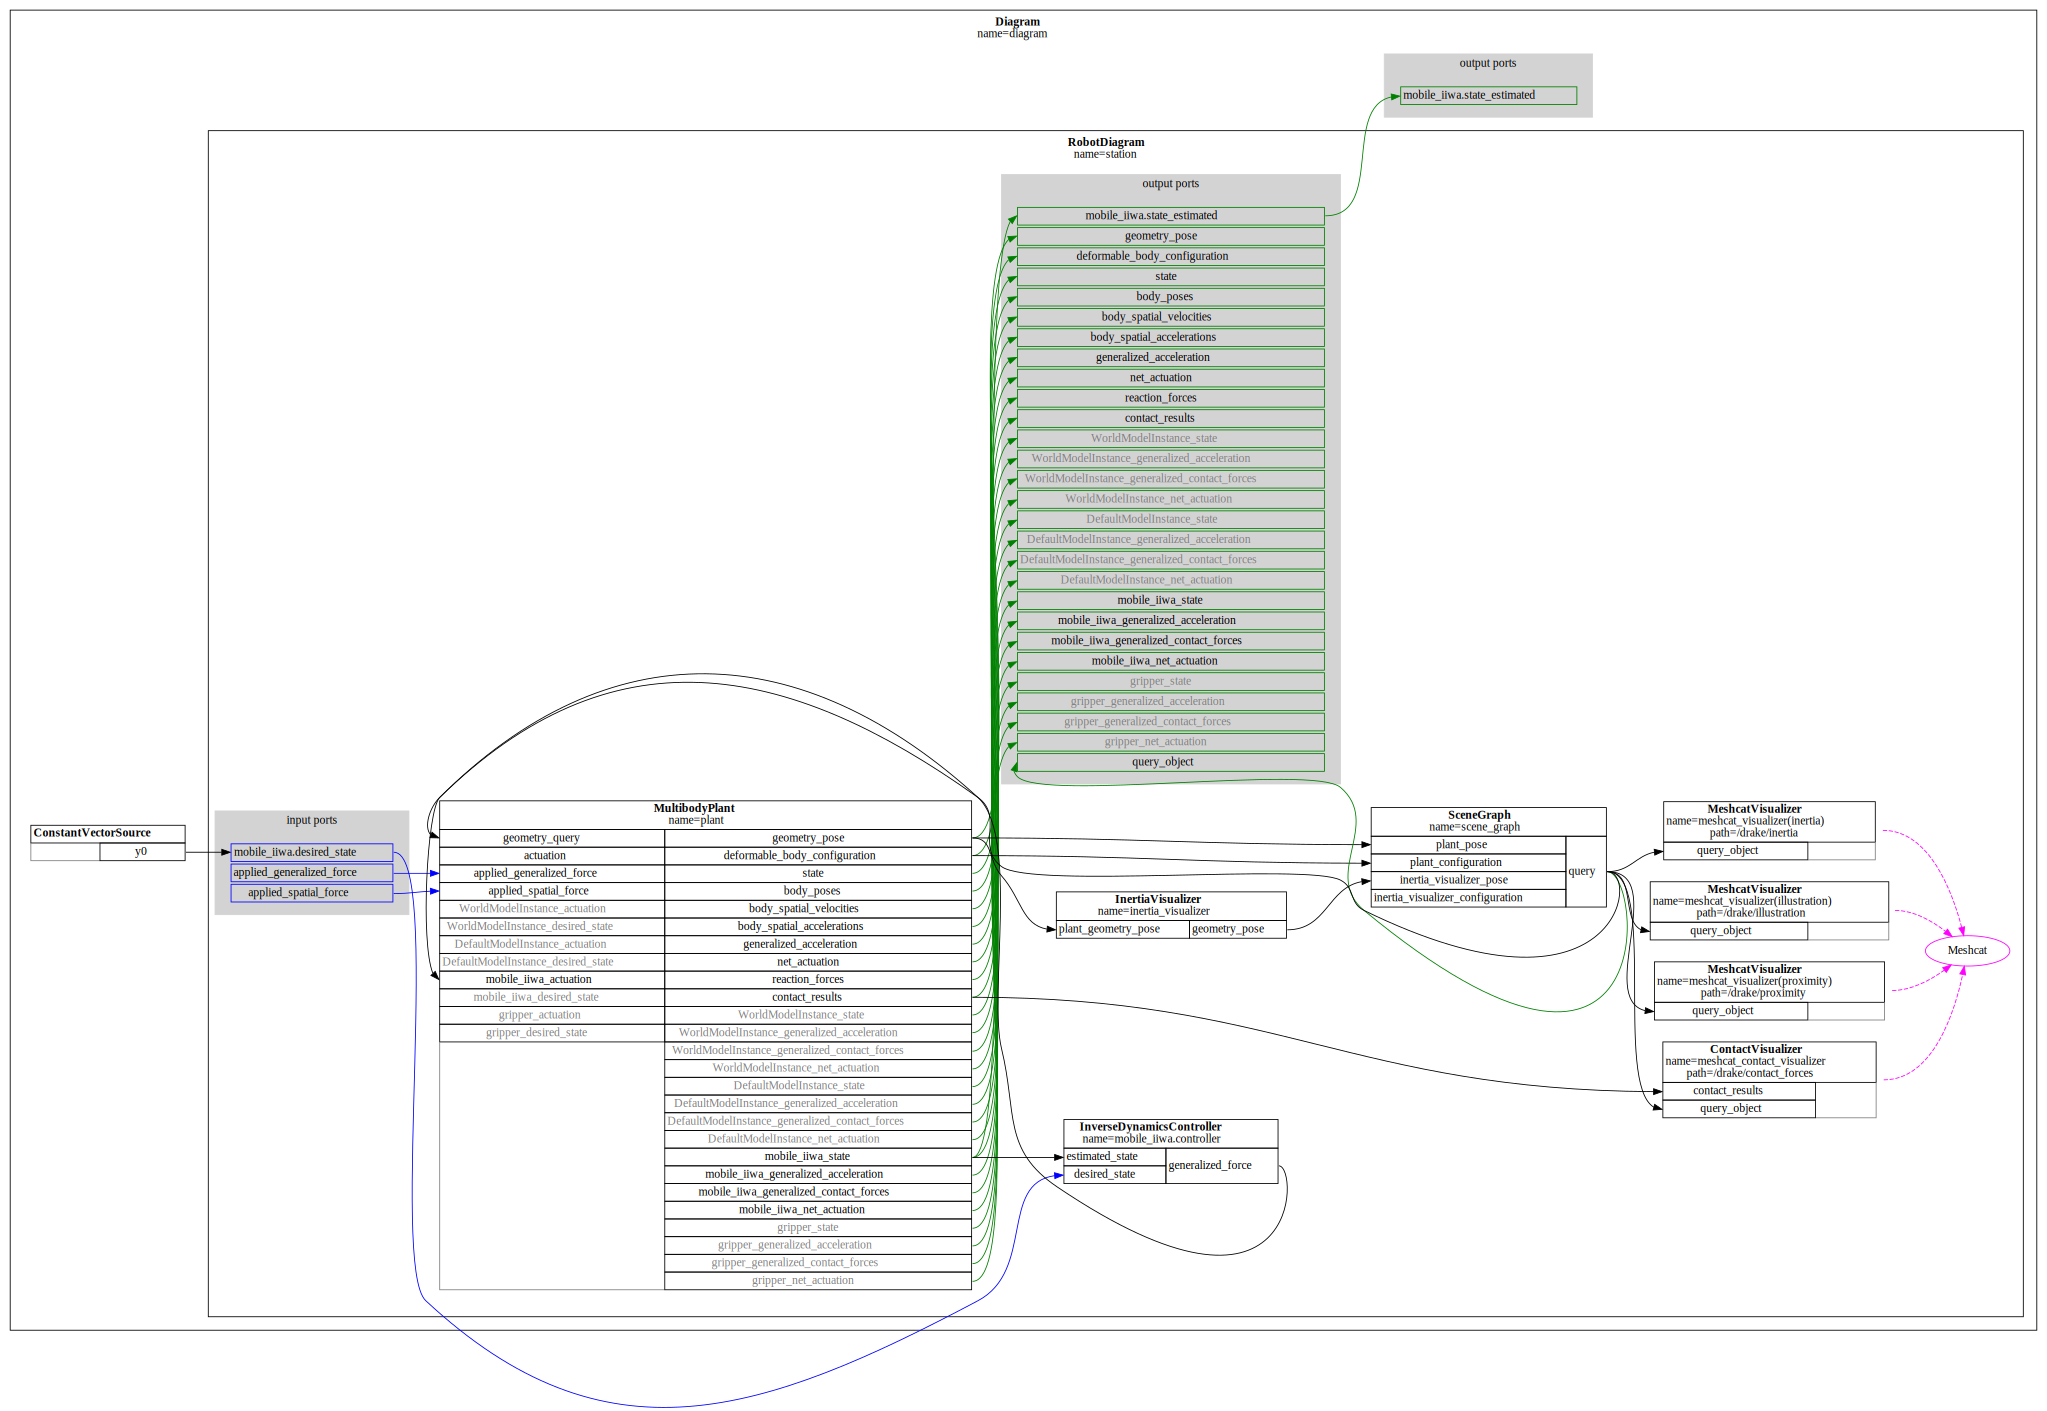

In [44]:
bot.print_diagram()
# context = bot.station.GetMyContextFromRoot(bot.diagram.CreateDefaultContext())
# bot.controller.GetInputPort("desired_state").FixValue(context, default_joint_angles)



In [6]:
# !pwd

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=92fbdad2-a4a9-4ef8-b493-c307060b34a1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>